In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
torch.cuda.set_device(2)

In [4]:
data=pd.read_csv('/data2/datasets/medstar/breast_pathology/lookup.csv')

In [5]:
data.head()

,File Name,Path,Notes
0,522a68932d261e3d9c07db8f93073d05.txt,Benign,NaN
1,1554f75ecbb52e6ade28b3158e47e4a5.txt,Benign,NaN
2,df2c9febb31db2795e65a057507e3c9a.txt,Benign,NaN
3,0d41aa9f8d070227f0ee83f73b4480c1.txt,Benign,NaN
4,df610ecbbffe4c0fad802718425ee7b3.txt,Benign,NaN


In [6]:
data.describe()

,File Name,Path,Notes
count,2658,2658,197
unique,2207,3,1
top,6310296a6e942e107bbd0da5bf082dbe.txt,Benign,HRL
freq,8,1924,197


In [7]:
data['Path'].value_counts()

Benign       1924
Malignant     729
benign          5
Name: Path, dtype: int64

In [8]:
data['Path'].unique()

array(['Benign', 'Malignant', 'benign'], dtype=object)

In [9]:
data['Path'].replace(regex='benign', value='Benign', inplace=True)

In [10]:
data['Path'].value_counts()

Benign       1929
Malignant     729
Name: Path, dtype: int64

In [11]:
data['Notes'].value_counts()

HRL    197
Name: Notes, dtype: int64

In [12]:
data['Notes'].unique()

array([nan, 'HRL'], dtype=object)

In [20]:
data['File Name '].isna().sum()

0

In [13]:
def func(x):
    text=open(os.path.join(path,x))
    return text.read()

In [14]:
path='/data2/datasets/medstar/breast_pathology/pathology_anonymized_report'

In [15]:
data['text']=data['File Name '].apply(func)

In [16]:
data.head()

,File Name,Path,Notes,text
0,522a68932d261e3d9c07db8f93073d05.txt,Benign,NaN,"Final Diagnosis\n\nBREAST, LEFT, BIOPSY;\n -\t..."
1,1554f75ecbb52e6ade28b3158e47e4a5.txt,Benign,NaN,Source of Specimen\nA\tBRST BX EXC MRG\tLEFT B...
2,df2c9febb31db2795e65a057507e3c9a.txt,Benign,NaN,Source of Specimen\nA\tRIGHT BREAST 9 GAUGE\n\...
3,0d41aa9f8d070227f0ee83f73b4480c1.txt,Benign,NaN,Source of Specimen\nA\tLT BREAST BX 9 GAUGE\n...
4,df610ecbbffe4c0fad802718425ee7b3.txt,Benign,NaN,Source of Specimen\nA\t9 GAUGE RT BREAST STERE...


In [38]:
data.duplicated('File Name ').sum()

451

In [44]:
data['File Name '].value_counts()

6310296a6e942e107bbd0da5bf082dbe.txt    8
e001bc7376389d312b44c0776d7bc21c.txt    5
e15afda0f6a3ee205f908ff6816d4469.txt    5
2595d31ad5efe0a2ad65df21683883b2.txt    4
1f4d1c8291b76e6c4a6b7aed722ae660.txt    4
                                       ..
d7a266d456c65d16b1aa4939f7cd557e.txt    1
6e0c4103483cb11cdf1ba8a0be583080.txt    1
56f8b9d4e52e0b168320daa2e478fb86.txt    1
ff1387130a61f15b93874c7f30d0f0c2.txt    1
410c88d69d2126e3d2de06033675e25f.txt    1
Name: File Name , Length: 2207, dtype: int64

In [45]:
data[data['File Name ']=='6310296a6e942e107bbd0da5bf082dbe.txt']

,File Name,Path,Notes,text
1405,6310296a6e942e107bbd0da5bf082dbe.txt,Malignant,NaN,"Final Diagnosis\nRight breast (7 o'clock), cor..."
1406,6310296a6e942e107bbd0da5bf082dbe.txt,Malignant,NaN,"Final Diagnosis\nRight breast (7 o'clock), cor..."
1408,6310296a6e942e107bbd0da5bf082dbe.txt,Malignant,NaN,"Final Diagnosis\nRight breast (7 o'clock), cor..."
1409,6310296a6e942e107bbd0da5bf082dbe.txt,Malignant,NaN,"Final Diagnosis\nRight breast (7 o'clock), cor..."
1411,6310296a6e942e107bbd0da5bf082dbe.txt,Malignant,NaN,"Final Diagnosis\nRight breast (7 o'clock), cor..."
1412,6310296a6e942e107bbd0da5bf082dbe.txt,Malignant,NaN,"Final Diagnosis\nRight breast (7 o'clock), cor..."
1422,6310296a6e942e107bbd0da5bf082dbe.txt,Benign,NaN,"Final Diagnosis\nRight breast (7 o'clock), cor..."
1423,6310296a6e942e107bbd0da5bf082dbe.txt,Benign,NaN,"Final Diagnosis\nRight breast (7 o'clock), cor..."


In [17]:
data.drop_duplicates('File Name ',inplace=True)

In [48]:
data.duplicated().sum()

0

# Preparing Pathology data

In [18]:
df3=pd.DataFrame(data['text'])

In [19]:
df3.head()

,text
0,"Final Diagnosis\n\nBREAST, LEFT, BIOPSY;\n -\t..."
1,Source of Specimen\nA\tBRST BX EXC MRG\tLEFT B...
2,Source of Specimen\nA\tRIGHT BREAST 9 GAUGE\n\...
3,Source of Specimen\nA\tLT BREAST BX 9 GAUGE\n...
4,Source of Specimen\nA\t9 GAUGE RT BREAST STERE...


# Language Model

In [21]:
bs = 64  
mypath=Path('/data2/itahir/MedstarProject')
data_lm = (TextList.from_df(df3, path, cols='text')
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs))

In [22]:
data_lm.save('/data2/itahir/MedstarProject/p_data_lm2.pkl')

In [14]:
bs = 64  
mypath=Path('/data2/itahir/MedstarProject')

In [105]:
data_lm = load_data(mypath, 'p_data_lm2.pkl', bs=bs)

In [25]:
data_lm.show_batch()

idx,text
0,"clinical xxmaj information \n xxup age female presents with right breast fibroadenoma , small nodule at 1 o’clock , left breast . xxmaj procedure : xxmaj left breast xxup us - guided biopsy , 14-gauge . \n xxmaj gross xxmaj description \n xxmaj the specimen is submitted in one part . \n \n xxmaj specimen a is received in a single container with formalin and is"
1,xxup lastname \n \n xxmaj this report may contain tests developed by the xxmaj molecular xxmaj diagnostic xxmaj laboratory at xxmaj georgetown xxmaj university xxmaj hospital . xxmaj these tests have not been approved by the xxup u.s. xxmaj food and xxmaj drug xxmaj administration . xxmaj the xxup fda has determined that such approval is not necessary . xxmaj these tests are used for clinical purposes . xxmaj
2,"right breast mass , 1 ( 0 ) \n \n xxmaj resident xxmaj pathologist : xxup firstname xxup lastname \n xxmaj resident xxmaj pathologist : xxup firstname xxup lastname \n \n xxmaj this report may contain tests developed by the xxmaj molecular xxmaj diagnostic xxmaj laboratory at xxmaj georgetown xxmaj university xxmaj hospital . xxmaj these tests have not been approved by the xxup u.s. xxmaj food"
3,"tumor # 1 , xxup fsc ( 0 ) \n b : \t xxmaj brain tumor # 2 , 1 ( 0 ) \n c : \t xxmaj brain tumor # 3 , xxup fsc ( 0 ) \n d : \t xxmaj brain tumor # 4 , 1 ( 0 ) \n e : \t xxmaj brain tumor # 5 , 1 ( 0 )"
4,", xxup left , xxup needle xxup core xxup biopsy : \n - \t xxup poorly xxup differentiated xxup infiltrating xxup ductal xxup carcinoma xxup corresponding xxup to xxup elston xxup 's xxup score xxup of 8 ( xxup tubule xxup formation = 3 , xxup nuclear xxup pleomorphism = 3 , xxup mitotic xxup index = 2 ) . \n \n - \t xxup no xxup evidence"


In [27]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


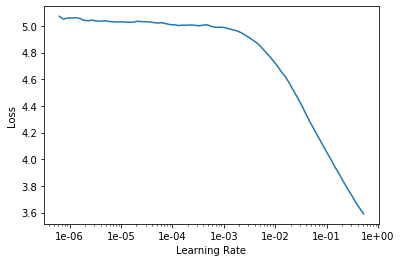

In [29]:
learn.recorder.plot(skip_end=15)

In [30]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))  

epoch,train_loss,valid_loss,accuracy,time
0,0.829349,0.779220,0.824784,00:14


In [31]:
learn.save('p_fit2_head')

In [32]:
learn.load('p_fit2_head');

In [33]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 9.12E-04


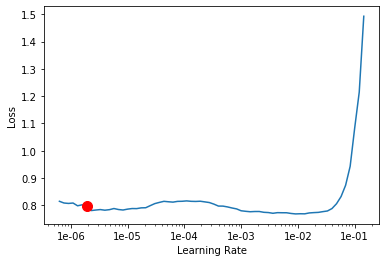

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.fit_one_cycle(4, slice(1e-6,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.687354,0.672238,0.840464,00:19
1,0.540035,0.582882,0.859759,00:19
2,0.502658,0.544438,0.867648,00:19
3,0.436378,0.534855,0.870613,00:19


In [36]:
learn.save('p_fine_2tuned')

In [37]:
learn.load('p_fine_2tuned');

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


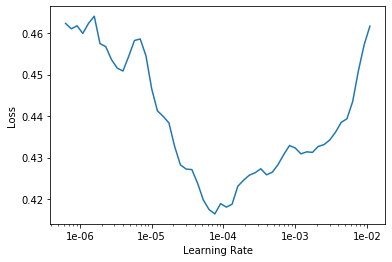

In [39]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [40]:
learn.fit_one_cycle(4, 1e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.447037,0.533907,0.871024,00:19
1,0.444074,0.532169,0.871512,00:19
2,0.439750,0.529957,0.872126,00:19
3,0.442537,0.530885,0.872049,00:19


In [41]:
learn.save('p_fine_2tuned_10')

In [63]:
learn.load('p_fine_2tuned_10');

In [64]:
learn.save_encoder('p_fine_tuned_enc_6')

# Data Split

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

In [53]:
data.to_csv('p_data')

In [4]:
data=pd.read_csv('p_data')

In [5]:
data.head()

,Unnamed: 0,File Name,Path,Notes,text
0,0,522a68932d261e3d9c07db8f93073d05.txt,Benign,NaN,"Final Diagnosis\n\nBREAST, LEFT, BIOPSY;\n -\t..."
1,1,1554f75ecbb52e6ade28b3158e47e4a5.txt,Benign,NaN,Source of Specimen\nA\tBRST BX EXC MRG\tLEFT B...
2,2,df2c9febb31db2795e65a057507e3c9a.txt,Benign,NaN,Source of Specimen\nA\tRIGHT BREAST 9 GAUGE\n\...
3,3,0d41aa9f8d070227f0ee83f73b4480c1.txt,Benign,NaN,Source of Specimen\nA\tLT BREAST BX 9 GAUGE\n...
4,4,df610ecbbffe4c0fad802718425ee7b3.txt,Benign,NaN,Source of Specimen\nA\t9 GAUGE RT BREAST STERE...


In [6]:
data.drop('Unnamed: 0', axis=1,inplace=True)

In [7]:
data.columns

Index(['File Name ', 'Path', 'Notes', 'text'], dtype='object')

In [8]:
data.head()

,File Name,Path,Notes,text
0,522a68932d261e3d9c07db8f93073d05.txt,Benign,NaN,"Final Diagnosis\n\nBREAST, LEFT, BIOPSY;\n -\t..."
1,1554f75ecbb52e6ade28b3158e47e4a5.txt,Benign,NaN,Source of Specimen\nA\tBRST BX EXC MRG\tLEFT B...
2,df2c9febb31db2795e65a057507e3c9a.txt,Benign,NaN,Source of Specimen\nA\tRIGHT BREAST 9 GAUGE\n\...
3,0d41aa9f8d070227f0ee83f73b4480c1.txt,Benign,NaN,Source of Specimen\nA\tLT BREAST BX 9 GAUGE\n...
4,df610ecbbffe4c0fad802718425ee7b3.txt,Benign,NaN,Source of Specimen\nA\t9 GAUGE RT BREAST STERE...


In [61]:
data['Path'].value_counts()

Benign       1624
Malignant     583
Name: Path, dtype: int64

In [151]:
for train_index, test_index in split.split(data,data['Path']):
    train=data.loc[train_index]
    test=data.loc[test_index]

# Classifier

In [106]:
data_clas = TextDataBunch.from_df(path=mypath, train_df=train, valid_df=test, text_cols=['text'], label_cols='Path', 
                                  vocab=data_lm.vocab)

In [107]:
data_clas.save('p_data_clas1.pkl')

In [108]:
data_clas = load_data(mypath, 'p_data_clas1.pkl', bs=bs)

In [68]:
data_clas.show_batch()

text,target
xxbos xxmaj addendum \n xxmaj molecular xxmaj diagnostics xxmaj laboratory xxmaj report \n xxup her-2 xxmaj gene xxmaj amplification by xxmaj fluorescent xxmaj in - xxmaj situ xxmaj hybridization ( xxup fish ) \n \n xxmaj tissue / block : \t xxup a7 \n \n xxmaj number of invasive tumor cells counted : \t 40 xxmaj cells \n \n xxup her-2 / xxup cen 17,Malignant
"xxbos xxmaj addendum \n xxmaj oncotype - xxup dx xxmaj breast xxmaj cancer xxmaj assay was performed at xxmaj genomic xxmaj health . a report has been received and summarized as follows : \n \n [ xxmaj for xxmaj specimen "" xxup xxunk "" representing right breast cancer ] \n xxmaj breast cancer recurrence score = 16 . \n xxup er xxmaj score = 7.2 (",Malignant
xxbos xxmaj addendum \n xxmaj oncotype - xxup dx xxmaj breast xxmaj cancer xxmaj assay was performed by xxmaj genomic xxmaj health . xxmaj results are reported as follows : \n \n xxmaj breast cancer recurrence score = 21 \n \n xxmaj the complete xxmaj genomic xxmaj health report was faxed to xxmaj dr. xxup firstname a copy of this report is maintained in xxup mguh xxmaj,Benign
"xxbos xxmaj addendum \n \n \n xxup molecular xxup diagnostic xxup report \n \n xxmaj her-2 / neu xxmaj gene xxmaj amplification by xxmaj fluorescent xxmaj in - xxmaj situ xxmaj hybridization ( xxup fish ) \n \n xxmaj breast , left , wide local excision ( xxmaj specimen "" b "" ) : \n - \t xxmaj intraductal and infiltrating ductal carcinoma . \n \n",Malignant
xxbos xxmaj source of xxmaj specimen \n a \t xxmaj level 1a neck dissection \n b \t xxmaj proximal margin lingual nerve \n c \t xxmaj anterior margin sublingual gland \n d \t xxmaj soft tissue margin of hyoid bone \n e \t xxmaj tongue \n f \t xxmaj retropharyngeal node \n g \t xxmaj anterior mucosal margin \n h \t xxmaj,Malignant


In [109]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [110]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3,metrics=[kappa, accuracy, error_rate])
learn.load_encoder('p_fine_tuned_enc_6'); #p_fine_tuned_enc_6

In [75]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


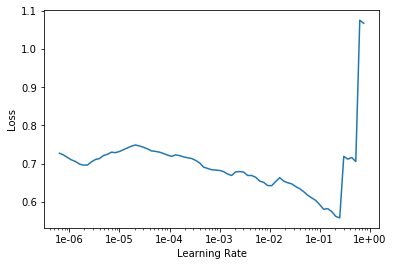

In [76]:
learn.recorder.plot()

In [78]:
learn.fit_one_cycle(1, slice(1e-5,1e-1), moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.572565,0.200781,0.801306,0.923077,0.076923,00:10


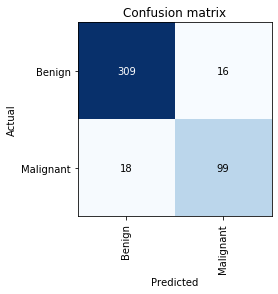

In [79]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [80]:
learn.save('p_first-00')

In [81]:
learn.load('p_first-00');

In [82]:
learn.freeze_to(-2)

In [83]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


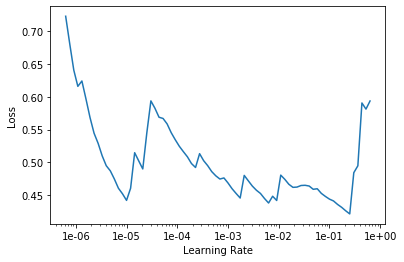

In [84]:
learn.recorder.plot()

In [85]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.448545,0.163543,0.865958,0.947964,0.052036,00:12


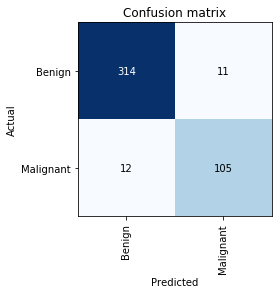

In [86]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [87]:
learn.save('p_second_00')

In [88]:
learn.load('p_second_00');

In [94]:
learn.freeze_to(-3)

In [95]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


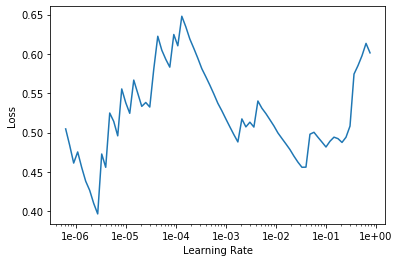

In [96]:
learn.recorder.plot()

In [97]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 1e-6, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.481773,0.158947,0.872832,0.950226,0.049774,00:16


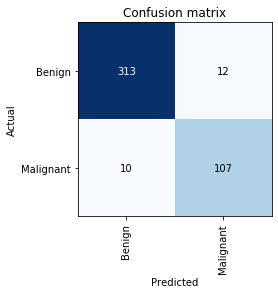

In [98]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [100]:
learn.save('p_third_00')

In [111]:
learn.load('p_third_00');

In [112]:
learn.unfreeze()

In [108]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


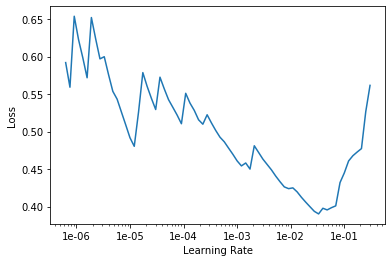

In [109]:
learn.recorder.plot()

In [105]:
learn.fit_one_cycle(10, 3e-6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.441844,0.165471,0.891062,0.957014,0.042986,00:19
1,0.480180,0.165605,0.891062,0.957014,0.042986,00:18
2,0.427836,0.161405,0.878282,0.952489,0.047511,00:21
3,0.400363,0.162839,0.878282,0.952489,0.047511,00:21
4,0.376107,0.177801,0.897074,0.959276,0.040724,00:21
5,0.387273,0.170065,0.897074,0.959276,0.040724,00:21
6,0.383746,0.167400,0.885019,0.954751,0.045249,00:21
7,0.437120,0.165183,0.891062,0.957014,0.042986,00:19
8,0.421444,0.161403,0.885019,0.954751,0.045249,00:21
9,0.416692,0.160243,0.878282,0.952489,0.047511,00:21


In [110]:
learn.fit_one_cycle(6, 3e-6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.356459,0.165581,0.891062,0.957014,0.042986,00:21
1,0.355822,0.164758,0.840901,0.938914,0.061086,00:23
2,0.390755,0.159253,0.878282,0.952489,0.047511,00:21
3,0.383302,0.164797,0.891062,0.957014,0.042986,00:22
4,0.363472,0.171405,0.897074,0.959276,0.040724,00:24
5,0.374327,0.161804,0.872832,0.950226,0.049774,00:22


In [113]:
learn.fit_one_cycle(5, 3e-6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.501025,0.167998,0.891062,0.957014,0.042986,00:19
1,0.471323,0.157951,0.878282,0.952489,0.047511,00:19
2,0.459158,0.165942,0.891062,0.957014,0.042986,00:20
3,0.432921,0.185042,0.903053,0.961538,0.038462,00:22
4,0.448925,0.178353,0.897074,0.959276,0.040724,00:20


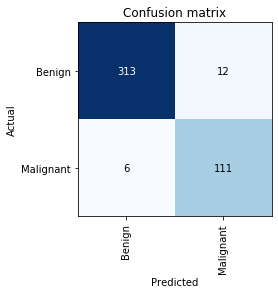

In [114]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [115]:
learn.save('p_fourth_00')

In [111]:
learn.load('p_fourth_00');

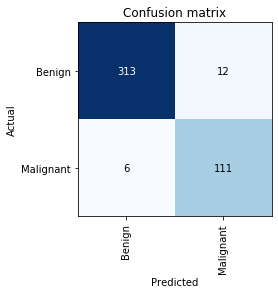

In [112]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [152]:
preds, _ = learn.get_preds(ds_type=DatasetType.Valid,ordered=True)

In [94]:
learn.data.classes

['Benign', 'Malignant']

In [150]:
#preds

In [153]:
labels = np.argmax(preds, 1)

In [154]:
len(labels)

442

In [155]:
test['labels']=labels

In [156]:
test.head()

,File Name,Path,Notes,text,labels
781,fdb3f70d41a349a80b33b71924ec3f8a.txt,Benign,NaN,Source of Specimen\nA\t14-G Sono Bx Core-Left ...,0
1804,552d33e98cc356a86b0c9faa98a8f649.txt,Benign,HRL,Source of Specimen\nA\tRight breast core\nClin...,0
1966,4bbc59e439a450d3fa0cec3aa5c668ff.txt,Benign,NaN,Source of Specimen\nA\t9G CORE BIOPSY BIGHT BR...,0
1723,990befce392fc9c645ee7ecba0920cb9.txt,Benign,NaN,Source of Specimen\nA\tRight breast core\nClin...,0
1624,f5e74088b9d3cbf0095415d3d2ee523f.txt,Malignant,NaN,Source of Specimen\nA\tLeft breast core\nClini...,1


In [157]:
#test['labels']

In [158]:
def func(x):
    if x==0:
        return 'Benign'
    else:
        return 'Malignant'

In [159]:
test['Predicted']=test['labels'].apply(func)

In [161]:
#test.head()

In [162]:
#test['Path']

In [163]:
((test['Predicted']=='Malignant') &(test['Path']=='Malignant')).sum()

111

In [164]:
((test['Predicted']=='Benign') &(test['Path']=='Benign')).sum()

313

In [169]:
(test["Predicted"]!=test['Path']).sum()

18

In [170]:
mis_clas_df=test[test["Predicted"]!=test['Path']]

In [130]:
#test_predictions_direct = [learn.data.classes[int(x)] for x in labels]

In [174]:
(mis_clas_df['Path']=='Malignant').sum()

6

In [173]:
mis_clas_df[mis_clas_df['Path']=='Malignant']

,File Name,Path,Notes,text,labels,Predicted
1222,21d07a7c3300b8fc16e17c229e599a2a.txt,Malignant,NaN,Addendum\nImmunohistochemical investigation of...,0,Benign
164,1009b244568b4768f4c04dea70921b00.txt,Malignant,NaN,Source of Specimen\nA\t14 G CORE BX 12:00 LEFT...,0,Benign
135,bd4dd5f61b4e19fa6fbb610e37e1c097.txt,Malignant,NaN,Source of Specimen\nA\t14 GAUGE CORE LEFT AXIL...,0,Benign
802,c61825924ba2762602a37625c5b3ea93.txt,Malignant,NaN,Source of Specimen\nA\tLeft Axillary Lymph Nod...,0,Benign
1449,c89ecb7d8631446c22a8abdda70e9092.txt,Malignant,NaN,Source of Specimen\nA\tLeft breast with calcif...,0,Benign
1743,df8cdc476f7ca5bf816f1c7ff8824f22.txt,Malignant,NaN,Source of Specimen\nA\tLeft breast core axilla...,0,Benign


In [175]:
df1=mis_clas_df[mis_clas_df['Path']=='Malignant']

In [181]:
df1.to_csv('missed_malignant.csv')

In [177]:
(mis_clas_df['Path']=='Benign').sum()

12

In [178]:
df2=mis_clas_df[mis_clas_df['Path']=='Benign'] #Benign

In [180]:
df2

,File Name,Path,Notes,text,labels,Predicted
1748,cb27076274f898ebee807491d9527440.txt,Benign,NaN,Addendum\nImmunohistochemical ER/PgR and HER2 ...,1,Malignant
162,708a74e0d2426d20667bb594b45af3b9.txt,Benign,NaN,Source of Specimen\nA\tRIGHT BREAST SENTINEL N...,1,Malignant
1689,8c7c85c1d65506d68373c0cf9b0d6a1a.txt,Benign,NaN,Source of Specimen\nA\tRIGHT BREAST NEEDLE COR...,1,Malignant
1040,a83be285a275cca9bda178e8ff5be5d6.txt,Benign,NaN,Addendum\nImmunohistochemical ER/PR and HER2/n...,1,Malignant
2004,8c5566cdd658c752ba5028e4f56e48db.txt,Benign,NaN,Source of Specimen\nA\tLeft Lymph Node FNA Cli...,1,Malignant
203,9e870d550157863765e58b47c3f987c0.txt,Benign,NaN,Source of Specimen\nA\tLEFT SENTINEL NODE #1\n...,1,Malignant
868,aa797da4657d9bb96d7c311947eb6199.txt,Benign,NaN,Addendum\nGenomic Health OncoType-DX Breast As...,1,Malignant
1008,2adaa96df353f6500cf9ca6bb946ef42.txt,Benign,HRL,Source of Specimen\nA\tRight Sentinel Node #1\...,1,Malignant
1940,f2c9f4270b4749dab1d9b94019858b4b.txt,Benign,NaN,"Addendum\nPer clinician's request, the focus o...",1,Malignant
2118,6f171b512ff6ab81950a4439e8902084.txt,Benign,NaN,Source of Specimen\nA\tLeft Breast Bx\n\nThis ...,1,Malignant


In [182]:
df2.to_csv('missed_Benign.csv')